# 2018 LST Bootcamp walkthrough

<div align="center" style="font-size: 2rem">

<img heoght="300px" src="https://cta-observatory.github.io/ctapipe/_images/ctapipe_logo.png" alt="ctapipe"/>


<p style="text-align: center;">LST Analysis Bootcamp</p>

<p style="text-align: center">Padova, 26.11.2018</p>

<p style="text-align: center">Maximilian Nöthe (@maxnoe) & Kai A. Brügge (@mackaiver)</p>

</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize']

[12.0, 8.0]

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

## General Information

### Design

* DL0 → DL3 analysis

* Currently some R0 → DL0 code to be able to analyze simtel files

* ctapipe is built upon the Scientific Python Stack, core dependencies are
  * numpy
  * scipy
  * astropy

### Developement

* ctapipe is developed as Open Source Software (Currently under MIT License) at <https://github.com/cta-observatory/ctapipe>

* We use the "Github-Workflow": 
  * Few people (e.g. @kosack, @mackaiver) have write access to the main repository
  * Contributors fork the main repository and work on branches
  * Pull Requests are merged after Code Review and automatic execution of the test suite

* Early developement stage ⇒ backwards-incompatible API changes might and will happen 

* Many open design questions ⇒ Core Developer Meeting in the second week of December in Dortmund

### What's there?

* Reading simtel simulation files
* Simple calibration, cleaning and feature extraction functions
* Camera and Array plotting
* Coordinate frames and transformations 
* Stereo-reconstruction using line intersections
  
 

### What's still missing?

* Easy to use IO of analysis results to standard data formats (e.g. FITS, hdf5)
* Easy to use "analysis builder"
* A "Standard Analysis"
* Good integration with machine learning techniques
* IRF calculation 
* Defining APIs for IO, instrument description access etc.
* Most code only tested on HESSIO simulations
* Documentation, e.g. formal definitions of coordinate frames 
 
 

### What can you do?

* Report issues
  * Hard to get started? Tell us where you are stuck
  * Tell user stories
  * Missing features

* Start contributing
  * ctapipe needs more workpower
  * Implement new reconstruction features

## A simple hillas analysis

### Reading in simtel files

In [3]:
from ctapipe.io import event_source
from ctapipe.utils.datasets import get_dataset_path

input_url = get_dataset_path('gamma_test_large.simtel.gz')

# event_source() automatically detects what kind of file we are giving it,
# if already supported by ctapipe
source = event_source(input_url, max_events=49)

print(type(source))

<class 'ctapipe.io.simteleventsource.SimTelEventSource'>


In [4]:
for event in source:
    print('Id: {}, E = {:1.3f}, Telescopes: {}'.format(event.count, event.mc.energy, len(event.r0.tel)))

Id: 0, E = 0.571 TeV, Telescopes: 4
Id: 1, E = 1.864 TeV, Telescopes: 9
Id: 2, E = 1.864 TeV, Telescopes: 4


Id: 3, E = 1.864 TeV, Telescopes: 17
Id: 4, E = 1.864 TeV, Telescopes: 2
Id: 5, E = 0.464 TeV, Telescopes: 7


Id: 6, E = 0.017 TeV, Telescopes: 2


Id: 7, E = 76.426 TeV, Telescopes: 4
Id: 8, E = 76.426 TeV, Telescopes: 16
Id: 9, E = 76.426 TeV, Telescopes: 3
Id: 10, E = 0.267 TeV, Telescopes: 5
Id: 11, E = 0.010 TeV, Telescopes: 2
Id: 12, E = 1.407 TeV, Telescopes: 3
Id: 13, E = 1.407 TeV, Telescopes: 3


Id: 14, E = 0.121 TeV, Telescopes: 10
Id: 15, E = 0.032 TeV, Telescopes: 4
Id: 16, E = 0.073 TeV, Telescopes: 2
Id: 17, E = 0.129 TeV, Telescopes: 3
Id: 18, E = 0.129 TeV, Telescopes: 2
Id: 19, E = 10.220 TeV, Telescopes: 2
Id: 20, E = 10.220 TeV, Telescopes: 4
Id: 21, E = 10.220 TeV, Telescopes: 4


Id: 22, E = 0.055 TeV, Telescopes: 2
Id: 23, E = 0.100 TeV, Telescopes: 3
Id: 24, E = 0.079 TeV, Telescopes: 5


Id: 25, E = 0.127 TeV, Telescopes: 7
Id: 26, E = 3.923 TeV, Telescopes: 4
Id: 27, E = 3.923 TeV, Telescopes: 2
Id: 28, E = 3.923 TeV, Telescopes: 4
Id: 29, E = 0.147 TeV, Telescopes: 6
Id: 30, E = 0.974 TeV, Telescopes: 6
Id: 31, E = 0.974 TeV, Telescopes: 3
Id: 32, E = 0.474 TeV, Telescopes: 4
Id: 33, E = 0.474 TeV, Telescopes: 4


Id: 34, E = 0.110 TeV, Telescopes: 2
Id: 35, E = 0.103 TeV, Telescopes: 2
Id: 36, E = 0.120 TeV, Telescopes: 4
Id: 37, E = 0.078 TeV, Telescopes: 4
Id: 38, E = 0.079 TeV, Telescopes: 2
Id: 39, E = 0.592 TeV, Telescopes: 4


Id: 40, E = 0.066 TeV, Telescopes: 6
Id: 41, E = 0.126 TeV, Telescopes: 3
Id: 42, E = 0.126 TeV, Telescopes: 2
Id: 43, E = 0.129 TeV, Telescopes: 2


Id: 44, E = 0.017 TeV, Telescopes: 3


Id: 45, E = 0.053 TeV, Telescopes: 2
Id: 46, E = 0.009 TeV, Telescopes: 2
Id: 47, E = 0.248 TeV, Telescopes: 4
Id: 48, E = 0.248 TeV, Telescopes: 11


Each event is a `DataContainer` holding several `Field`s of data, which can be containers or just numbers.
Let's look a one event:

In [5]:
event

ctapipe.io.containers.DataContainer:
                    event_type: Event type
                       index.*: event indexing information
                          r0.*: Raw Data
                          r1.*: R1 Calibrated Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: Reconstructed Shower Information
                          mc.*: Monte-Carlo data
                    mcheader.*: Monte-Carlo run header data
                        trig.*: central trigger information
                         count: number of events processed
                        inst.*: instrumental information
                   pointing[*]: Telescope pointing positions
                 calibration.*: Container for calibration coefficients for the
                                current event

In [6]:
event.inst.subarray.camera_types

[CameraGeometry(cam_id='ASTRICam', pix_type='rectangular', npix=2368, cam_rot=0.0 rad, pix_rot=0.0 deg),
 CameraGeometry(cam_id='FlashCam', pix_type='hexagonal', npix=1764, cam_rot=0.0 rad, pix_rot=0.0 deg),
 CameraGeometry(cam_id='LSTCam', pix_type='hexagonal', npix=1855, cam_rot=0.0 rad, pix_rot=100.89299992867878 deg)]

In [7]:
len(event.r0.tel), len(event.r1.tel)

(11, 11)

### Data calibration

The `CameraCalibrator` calibrates the event (obtaining the `dl1` images).

In [8]:
from ctapipe.calib import CameraCalibrator

calibrator = CameraCalibrator(subarray=source.subarray)

In [9]:
calibrator(event)

### Event displays

Let's use ctapipe's plotting facilities to plot the telescope images

In [10]:
event.dl1.tel.keys()

dict_keys([1, 2, 3, 4, 5, 7, 9, 11, 13, 16, 19])

In [11]:
tel_id = 4

In [12]:
camera = event.inst.subarray.tel[tel_id].camera
dl1 = event.dl1.tel[tel_id]

camera, dl1

(CameraGeometry(cam_id='LSTCam', pix_type='hexagonal', npix=1855, cam_rot=0.0 rad, pix_rot=100.89299992867878 deg),
 ctapipe.io.containers.DL1CameraContainer:
                          image: Numpy array of camera image, after waveform
                                 extraction.Shape: (n_pixel)
                     pulse_time: Numpy array containing position of the pulse as
                                 determined by the extractor.Shape: (n_pixel,
                                 n_samples))

In [13]:
dl1.image

array([ 1.89778323, -1.79276736,  1.83730035, ..., -1.33072389,
        1.09462546,  0.36395849])

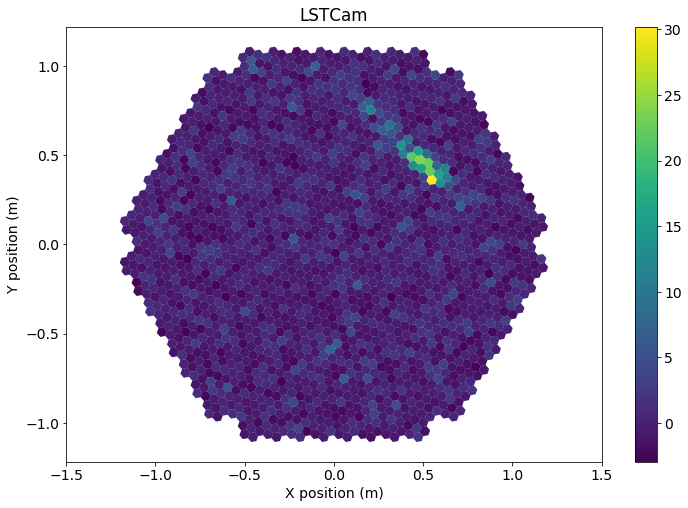

In [14]:
from ctapipe.visualization import CameraDisplay

display = CameraDisplay(camera)

# right now, there might be one image per gain channel.
# This will change as soon as 
display.image = dl1.image
display.add_colorbar()

### Image Cleaning

In [15]:
from ctapipe.image.cleaning import tailcuts_clean

In [16]:
# unoptimized cleaning levels, copied from 
# https://github.com/tudo-astroparticlephysics/cta_preprocessing
cleaning_level = {
    'ASTRICam': (5, 7, 2),  # (5, 10)?
    'LSTCam': (3.5, 7.5, 2),  # ?? (3, 6) for Abelardo...
    'FlashCam': (4, 8, 2),  # there is some scaling missing?
}

In [17]:
boundary, picture, min_neighbors = cleaning_level[camera.cam_id]

clean = tailcuts_clean(
    camera, 
    dl1.image,
    boundary_thresh=boundary,
    picture_thresh=picture,
    min_number_picture_neighbors=min_neighbors
)

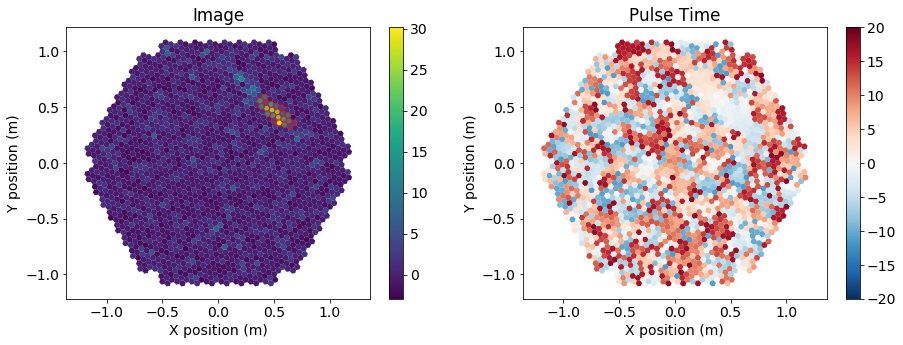

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

d1 = CameraDisplay(camera, ax=ax1)
d2 = CameraDisplay(camera, ax=ax2)

ax1.set_title('Image')
d1.image = dl1.image
d1.add_colorbar(ax=ax1)

ax2.set_title('Pulse Time')
d2.image = dl1.pulse_time - np.average(dl1.pulse_time, weights=dl1.image)
d2.cmap = 'RdBu_r'
d2.add_colorbar(ax=ax2)
d2.set_limits_minmax(-20,20)

d1.highlight_pixels(clean, color='red', linewidth=1)

### Image Parameters

In [19]:
from ctapipe.image import hillas_parameters, leakage, concentration
from ctapipe.image.timing_parameters import timing_parameters
from ctapipe.image.cleaning import number_of_islands
from ctapipe.image.hillas import camera_to_shower_coordinates

In [20]:
hillas = hillas_parameters(camera[clean], dl1.image[clean])

print(hillas)

{'intensity': 293.30155951087204,
 'kurtosis': 2.1156919045421128,
 'length': <Quantity 0.09458967 m>,
 'phi': <Angle 0.71440377 rad>,
 'psi': <Angle -0.71608043 rad>,
 'r': <Quantity 0.67893267 m>,
 'skewness': -0.15071030025860072,
 'width': <Quantity 0.03181493 m>,
 'x': <Quantity 0.51292278 m>,
 'y': <Quantity 0.44481434 m>}


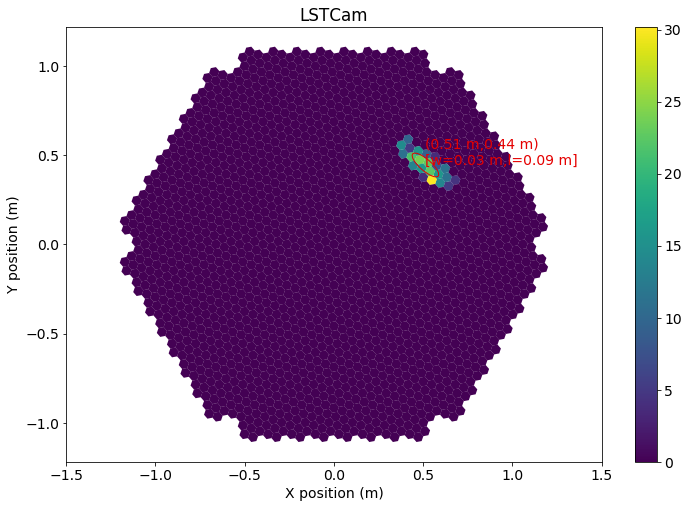

In [21]:
display = CameraDisplay(camera)

# set "unclean" pixels to 0
cleaned = dl1.image.copy()
cleaned[~clean] = 0.0

display.image = cleaned
display.add_colorbar()

display.overlay_moments(hillas, color='xkcd:red')

In [22]:
timing = timing_parameters(
    camera,
    dl1.image,
    dl1.pulse_time,
    hillas,
    clean
)

print(timing)

{'deviation': 0.39611107257385286,
 'intercept': 9.721400753364208,
 'intercept_err': 0.08208715157421013,
 'slope': <Quantity -7.8687458 1 / m>,
 'slope_err': 0.8678236176858639}


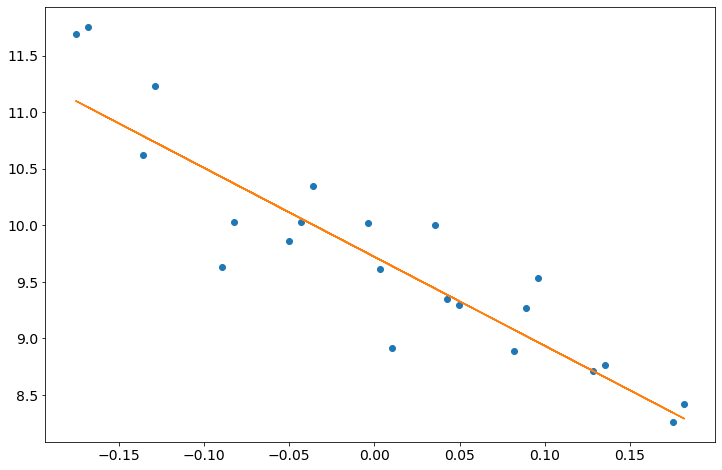

In [23]:
long, trans = camera_to_shower_coordinates(
    camera.pix_x, camera.pix_y,hillas.x, hillas.y, hillas.psi
)

plt.plot(long[clean], dl1.pulse_time[clean], 'o')
plt.plot(long[clean], timing.slope * long[clean] + timing.intercept)

In [24]:
l = leakage(camera, dl1.image, clean)
print(l)

{'intensity_width_1': 0.0,
 'intensity_width_2': 0.0,
 'pixels_width_1': 0.0,
 'pixels_width_2': 0.0}


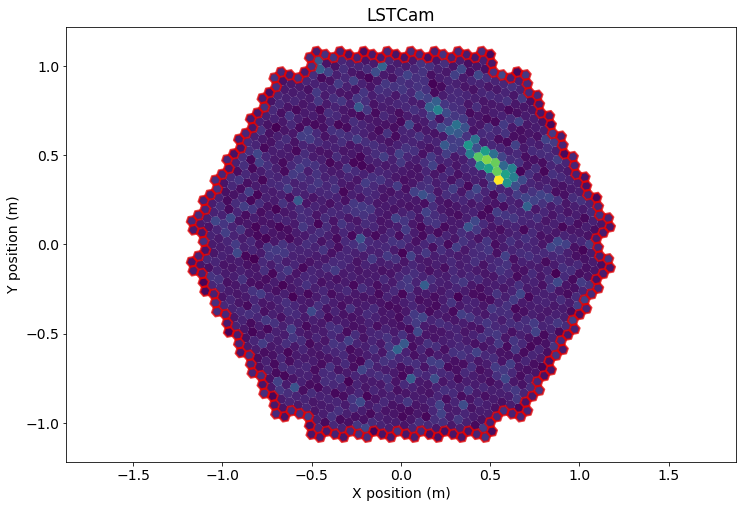

In [25]:
disp = CameraDisplay(camera)
disp.image = dl1.image
disp.highlight_pixels(camera.get_border_pixel_mask(1), linewidth=2, color='xkcd:red')

In [26]:
n_islands, island_id = number_of_islands(camera, clean)

print(n_islands)

1


In [27]:
conc = concentration(camera, dl1.image, hillas)
print(conc)

{'cog': 0.21367737478242063,
 'core': 0.3447089938879211,
 'pixel': 0.10290955727305243}


### Putting it all together / Stereo reconstruction

In [28]:
import astropy.units as u
from astropy.coordinates import SkyCoord, AltAz

from ctapipe.io import event_source
from ctapipe.utils.datasets import get_dataset_path

from ctapipe.calib import CameraCalibrator

from ctapipe.image.cleaning import tailcuts_clean, number_of_islands
from ctapipe.image import hillas_parameters, leakage, concentration
from ctapipe.image.timing_parameters import timing_parameters

from ctapipe.reco import HillasReconstructor

from ctapipe.io import HDF5TableWriter

from copy import deepcopy
import tempfile

# unoptimized cleaning levels, copied from 
# https://github.com/tudo-astroparticlephysics/cta_preprocessing
cleaning_level = {
    'ASTRICam': (5, 7, 2),  # (5, 10)?
    'LSTCam': (3.5, 7.5, 2),  # ?? (3, 6) for Abelardo...
    'FlashCam': (4, 8, 2),  # there is some scaling missing?
}


input_url = get_dataset_path('gamma_test_large.simtel.gz')
source = event_source(input_url)

calibrator = CameraCalibrator(subarray=source.subarray)

horizon_frame = AltAz()

reco = HillasReconstructor()

f = tempfile.NamedTemporaryFile(suffix='.hdf5')

with HDF5TableWriter(f.name, mode='w', group_name='events') as writer:
    
    for event in source:
        print('Id: {}, E = {:1.3f}, Telescopes: {}'.format(event.count, event.mc.energy, len(event.r0.tel)))
        
        calibrator(event)

        # mapping of telescope_id to parameters for stereo reconstruction
        hillas_containers = {}
        telescope_pointings = {}
        time_gradients = {}

        for telescope_id, dl1 in event.dl1.tel.items():
            camera = event.inst.subarray.tels[telescope_id].camera
            image = dl1.image
            pulse_time = dl1.pulse_time

            boundary, picture, min_neighbors = cleaning_level[camera.cam_id]

            clean = tailcuts_clean(
                camera, 
                image,
                boundary_thresh=boundary,
                picture_thresh=picture,
                min_number_picture_neighbors=min_neighbors
            )

            # require more than five pixels after cleaning in each telescope
            if clean.sum() < 5:
                continue

            hillas_c = hillas_parameters(camera[clean], image[clean])
            leakage_c = leakage(camera, image, clean)
            n_islands, island_ids = number_of_islands(camera, clean)

            # remove events with high leakage
            if leakage_c.intensity_width_2 > 0.2:
                continue

            timing_c = timing_parameters(camera, image, pulse_time, hillas_c, clean)

            hillas_containers[telescope_id] = hillas_c

            # ssts have no timing in prod3b, so we'll use the skewness
            time_gradients[telescope_id] = timing_c.slope.value if camera.cam_id != 'ASTRICam' else hillas_c.skewness

            # this makes sure, that we get an arrow in the array plow for each telescope
            # might have the wrong direction though
            if abs(time_gradients[telescope_id]) < 0.2:
                time_gradients[telescope_id] = 1.0

            telescope_pointings[telescope_id] = SkyCoord(
                alt=event.mc.tel[telescope_id].altitude_raw * u.rad,
                az=event.mc.tel[telescope_id].azimuth_raw * u.rad,
                frame=horizon_frame
            )  
            
        # the array pointing is needed for the creation of the TiltedFrame to perform the 
        # impact point reconstruction
        array_pointing = SkyCoord(
            az=event.mcheader.run_array_direction[0],
            alt=event.mcheader.run_array_direction[1],
            frame=horizon_frame
        )

        if len(hillas_containers) > 1:
            stereo = reco.predict(
                hillas_containers, event.inst, array_pointing, telescope_pointings
            )

            writer.write('reconstructed', stereo)
            writer.write('true', event.mc)
    
            print('  Alt: {:.2f}°'.format(stereo.alt.deg))
            print('  Az: {:.2f}°'.format(stereo.az.deg))
            print('  Hmax: {:.0f}'.format(stereo.h_max))
            print('  CoreX: {:.1f}'.format(stereo.core_x))
            print('  CoreY: {:.1f}'.format(stereo.core_y))
        
        # save a nice event for plotting later
        if event.count == 3:
            plotting_event = deepcopy(event)
            plotting_hillas = hillas_containers
            plotting_timing = time_gradients
            plotting_stereo = stereo
    

Id: 0, E = 0.571 TeV, Telescopes: 4


  Alt: 66.37°
  Az: -7.85°
  Hmax: 8963 m
  CoreX: 114.8 m
  CoreY: -414.8 m
Id: 1, E = 1.864 TeV, Telescopes: 9


  Alt: 68.25°
  Az: -353.46°
  Hmax: 6798 m
  CoreX: -48.5 m
  CoreY: -394.6 m
Id: 2, E = 1.864 TeV, Telescopes: 4


  Alt: 68.49°
  Az: -354.35°
  Hmax: 7050 m
  CoreX: -419.5 m
  CoreY: -574.8 m
Id: 3, E = 1.864 TeV, Telescopes: 17


  Alt: 68.47°
  Az: -353.41°
  Hmax: 6655 m
  CoreX: 42.2 m
  CoreY: 67.4 m
Id: 4, E = 1.864 TeV, Telescopes: 2


  Alt: 68.64°
  Az: -353.31°
  Hmax: 6396 m
  CoreX: -1097.3 m
  CoreY: 474.8 m
Id: 5, E = 0.464 TeV, Telescopes: 7


  Alt: 71.92°
  Az: -1.07°
  Hmax: 8684 m
  CoreX: -66.1 m
  CoreY: 289.6 m
Id: 6, E = 0.017 TeV, Telescopes: 2


  Alt: 70.53°
  Az: -358.01°
  Hmax: 10685 m
  CoreX: -157.5 m
  CoreY: -221.7 m
Id: 7, E = 76.426 TeV, Telescopes: 4


  Alt: 73.99°
  Az: -354.24°
  Hmax: 9817 m
  CoreX: 11.9 m
  CoreY: -1121.4 m
Id: 8, E = 76.426 TeV, Telescopes: 16


  Alt: 75.26°
  Az: -353.94°
  Hmax: 5815 m
  CoreX: 137.1 m
  CoreY: 449.8 m
Id: 9, E = 76.426 TeV, Telescopes: 3


  Alt: 75.00°
  Az: -354.03°
  Hmax: 7485 m
  CoreX: 913.0 m
  CoreY: -995.4 m
Id: 10, E = 0.267 TeV, Telescopes: 5
Id: 11, E = 0.010 TeV, Telescopes: 2


Id: 12, E = 1.407 TeV, Telescopes: 3
Id: 13, E = 1.407 TeV, Telescopes: 3
Id: 14, E = 0.121 TeV, Telescopes: 10


  Alt: 67.41°
  Az: -0.73°
  Hmax: 13016 m
  CoreX: -163.9 m
  CoreY: -137.2 m
Id: 15, E = 0.032 TeV, Telescopes: 4


  Alt: 71.91°
  Az: -0.47°
  Hmax: 7848 m
  CoreX: 21.2 m
  CoreY: 65.8 m
Id: 16, E = 0.073 TeV, Telescopes: 2
Id: 17, E = 0.129 TeV, Telescopes: 3


  Alt: 70.31°
  Az: -353.32°
  Hmax: 4184 m
  CoreX: 186.6 m
  CoreY: -130.5 m
Id: 18, E = 0.129 TeV, Telescopes: 2
Id: 19, E = 10.220 TeV, Telescopes: 2
Id: 20, E = 10.220 TeV, Telescopes: 4
Id: 21, E = 10.220 TeV, Telescopes: 4
Id: 22, E = 0.055 TeV, Telescopes: 2


  Alt: 73.02°
  Az: -1.67°
  Hmax: 7389 m
  CoreX: -335.0 m
  CoreY: 8.7 m
Id: 23, E = 0.100 TeV, Telescopes: 3


  Alt: 68.86°
  Az: -350.50°
  Hmax: 7785 m
  CoreX: -123.7 m
  CoreY: -148.0 m
Id: 24, E = 0.079 TeV, Telescopes: 5


  Alt: 68.34°
  Az: -353.47°
  Hmax: 10671 m
  CoreX: -113.7 m
  CoreY: 91.9 m


Id: 25, E = 0.127 TeV, Telescopes: 7


  Alt: 70.11°
  Az: -4.55°
  Hmax: 8605 m
  CoreX: 23.1 m
  CoreY: -198.6 m
Id: 26, E = 3.923 TeV, Telescopes: 4


  Alt: 70.37°
  Az: -345.42°
  Hmax: 5987 m
  CoreX: 373.0 m
  CoreY: -194.6 m
Id: 27, E = 3.923 TeV, Telescopes: 2
Id: 28, E = 3.923 TeV, Telescopes: 4
Id: 29, E = 0.147 TeV, Telescopes: 6


  Alt: 70.10°
  Az: -3.79°
  Hmax: 5555 m
  CoreX: 131.2 m
  CoreY: 224.3 m
Id: 30, E = 0.974 TeV, Telescopes: 6


  Alt: 73.41°
  Az: -5.79°
  Hmax: 8489 m
  CoreX: 460.3 m
  CoreY: 328.2 m
Id: 31, E = 0.974 TeV, Telescopes: 3


  Alt: 73.11°
  Az: -6.73°
  Hmax: 7629 m
  CoreX: -84.8 m
  CoreY: 554.9 m
Id: 32, E = 0.474 TeV, Telescopes: 4


  Alt: 70.06°
  Az: -10.68°
  Hmax: 7234 m
  CoreX: -123.8 m
  CoreY: -478.5 m
Id: 33, E = 0.474 TeV, Telescopes: 4


  Alt: 69.83°
  Az: -13.61°
  Hmax: 7167 m
  CoreX: 448.8 m
  CoreY: -303.2 m
Id: 34, E = 0.110 TeV, Telescopes: 2


  Alt: 71.91°
  Az: -358.11°
  Hmax: 8842 m
  CoreX: -221.9 m
  CoreY: -7.7 m
Id: 35, E = 0.103 TeV, Telescopes: 2
Id: 36, E = 0.120 TeV, Telescopes: 4


  Alt: 68.60°
  Az: -8.66°
  Hmax: 10768 m
  CoreX: 118.9 m
  CoreY: -206.3 m
Id: 37, E = 0.078 TeV, Telescopes: 4


  Alt: 68.58°
  Az: -355.25°
  Hmax: 9472 m
  CoreX: -170.6 m
  CoreY: -115.5 m
Id: 38, E = 0.079 TeV, Telescopes: 2


Id: 39, E = 0.592 TeV, Telescopes: 4


Id: 40, E = 0.066 TeV, Telescopes: 6


  Alt: 68.82°
  Az: -6.06°
  Hmax: 10677 m
  CoreX: 67.5 m
  CoreY: -14.0 m
Id: 41, E = 0.126 TeV, Telescopes: 3


  Alt: 71.57°
  Az: -355.17°
  Hmax: 7758 m
  CoreX: -210.1 m
  CoreY: -308.9 m
Id: 42, E = 0.126 TeV, Telescopes: 2
Id: 43, E = 0.129 TeV, Telescopes: 2


Id: 44, E = 0.017 TeV, Telescopes: 3


Id: 45, E = 0.053 TeV, Telescopes: 2


  Alt: 70.77°
  Az: -355.33°
  Hmax: 10482 m
  CoreX: 461.5 m
  CoreY: -97.6 m
Id: 46, E = 0.009 TeV, Telescopes: 2


Id: 47, E = 0.248 TeV, Telescopes: 4


  Alt: 71.94°
  Az: -0.06°
  Hmax: 10458 m
  CoreX: 467.2 m
  CoreY: 96.6 m
Id: 48, E = 0.248 TeV, Telescopes: 11


  Alt: 71.98°
  Az: -359.96°
  Hmax: 10188 m
  CoreX: 8.3 m
  CoreY: -147.3 m
Id: 49, E = 0.248 TeV, Telescopes: 4


  Alt: 71.83°
  Az: -359.98°
  Hmax: 8856 m
  CoreX: -450.0 m
  CoreY: 149.1 m
Id: 50, E = 5.327 TeV, Telescopes: 2


  Alt: 66.71°
  Az: -349.98°
  Hmax: 6980 m
  CoreX: -1059.0 m
  CoreY: 871.1 m
Id: 51, E = 5.327 TeV, Telescopes: 18


  Alt: 67.08°
  Az: -351.11°
  Hmax: 6521 m
  CoreX: -340.4 m
  CoreY: 145.5 m
Id: 52, E = 5.327 TeV, Telescopes: 2
Id: 53, E = 0.095 TeV, Telescopes: 2
Id: 54, E = 0.937 TeV, Telescopes: 2
Id: 55, E = 0.937 TeV, Telescopes: 2


  Alt: 69.82°
  Az: -6.77°
  Hmax: 9255 m
  CoreX: -650.0 m
  CoreY: -704.9 m
Id: 56, E = 0.937 TeV, Telescopes: 4


  Alt: 69.79°
  Az: -7.33°
  Hmax: 9587 m
  CoreX: -601.1 m
  CoreY: 133.3 m
Id: 57, E = 0.937 TeV, Telescopes: 2


  Alt: 70.15°
  Az: -6.80°
  Hmax: 9136 m
  CoreX: 414.7 m
  CoreY: 866.7 m
Id: 58, E = 0.161 TeV, Telescopes: 2
Id: 59, E = 0.407 TeV, Telescopes: 14


  Alt: 69.64°
  Az: -8.06°
  Hmax: 9542 m
  CoreX: -76.2 m
  CoreY: -88.8 m
Id: 60, E = 0.037 TeV, Telescopes: 3


  Alt: 67.22°
  Az: -358.15°
  Hmax: 13977 m
  CoreX: -437.6 m
  CoreY: 51.7 m
Id: 61, E = 0.020 TeV, Telescopes: 4


  Alt: 70.55°
  Az: -0.70°
  Hmax: 9237 m
  CoreX: 1.8 m
  CoreY: 123.1 m
Id: 62, E = 2.364 TeV, Telescopes: 4


  Alt: 65.91°
  Az: -359.40°
  Hmax: 7748 m
  CoreX: 573.7 m
  CoreY: 730.2 m
Id: 63, E = 0.710 TeV, Telescopes: 8


  Alt: 71.35°
  Az: -349.97°
  Hmax: 10258 m
  CoreX: 302.8 m
  CoreY: 222.5 m
Id: 64, E = 0.710 TeV, Telescopes: 2


  Alt: 71.12°
  Az: -348.22°
  Hmax: 10447 m
  CoreX: 677.4 m
  CoreY: -573.6 m
Id: 65, E = 1.158 TeV, Telescopes: 2


Id: 66, E = 0.055 TeV, Telescopes: 5


  Alt: 69.85°
  Az: -356.16°
  Hmax: 8673 m
  CoreX: -13.5 m
  CoreY: 160.4 m
Id: 67, E = 0.032 TeV, Telescopes: 2


Id: 68, E = 0.232 TeV, Telescopes: 3


  Alt: 68.56°
  Az: -5.28°
  Hmax: 10128 m
  CoreX: 484.4 m
  CoreY: -442.1 m
Id: 69, E = 0.232 TeV, Telescopes: 2
Id: 70, E = 22.299 TeV, Telescopes: 5


  Alt: 66.80°
  Az: -358.30°
  Hmax: 6775 m
  CoreX: 139.1 m
  CoreY: -855.5 m
Id: 71, E = 22.299 TeV, Telescopes: 12


  Alt: 63.74°
  Az: -356.20°
  Hmax: 7888 m
  CoreX: -170.7 m
  CoreY: 271.0 m
Id: 72, E = 0.118 TeV, Telescopes: 3


  Alt: 67.25°
  Az: -4.93°
  Hmax: 9275 m
  CoreX: 186.7 m
  CoreY: 290.8 m
Id: 73, E = 0.118 TeV, Telescopes: 3


  Alt: 67.35°
  Az: -4.97°
  Hmax: 8865 m
  CoreX: 205.6 m
  CoreY: -187.7 m
Id: 74, E = 0.118 TeV, Telescopes: 5


  Alt: 67.02°
  Az: -5.38°
  Hmax: 9031 m
  CoreX: -61.6 m
  CoreY: -336.3 m
Id: 75, E = 0.101 TeV, Telescopes: 2


Id: 76, E = 0.065 TeV, Telescopes: 2
Id: 77, E = 3.581 TeV, Telescopes: 2


  Alt: 71.05°
  Az: -350.78°
  Hmax: 9400 m
  CoreX: -382.5 m
  CoreY: -1149.8 m
Id: 78, E = 3.581 TeV, Telescopes: 5


  Alt: 71.11°
  Az: -350.72°
  Hmax: 8273 m
  CoreX: 188.4 m
  CoreY: -667.7 m
Id: 79, E = 0.768 TeV, Telescopes: 5


Id: 80, E = 0.290 TeV, Telescopes: 2
Id: 81, E = 0.060 TeV, Telescopes: 2
Id: 82, E = 2.967 TeV, Telescopes: 2
Id: 83, E = 2.967 TeV, Telescopes: 2
Id: 84, E = 0.142 TeV, Telescopes: 4


  Alt: 69.42°
  Az: -358.78°
  Hmax: 10535 m
  CoreX: -149.3 m
  CoreY: -367.3 m
Id: 85, E = 0.142 TeV, Telescopes: 2
Id: 86, E = 0.435 TeV, Telescopes: 2
Id: 87, E = 0.435 TeV, Telescopes: 2


Id: 88, E = 0.339 TeV, Telescopes: 4


Id: 89, E = 1.851 TeV, Telescopes: 4


  Alt: 69.58°
  Az: -2.82°
  Hmax: 7769 m
  CoreX: -879.3 m
  CoreY: 105.7 m
Id: 90, E = 1.851 TeV, Telescopes: 6


  Alt: 69.47°
  Az: -2.52°
  Hmax: 7770 m
  CoreX: -711.7 m
  CoreY: -250.7 m
Id: 91, E = 0.189 TeV, Telescopes: 11


  Alt: 70.61°
  Az: -3.62°
  Hmax: 8684 m
  CoreX: -51.5 m
  CoreY: -92.9 m
Id: 92, E = 0.037 TeV, Telescopes: 3


Id: 93, E = 1.620 TeV, Telescopes: 4


  Alt: 69.32°
  Az: -7.08°
  Hmax: 7291 m
  CoreX: -867.7 m
  CoreY: -195.8 m
Id: 94, E = 1.620 TeV, Telescopes: 2


  Alt: 69.31°
  Az: -7.58°
  Hmax: 7869 m
  CoreX: -346.0 m
  CoreY: -1083.3 m
Id: 95, E = 1.620 TeV, Telescopes: 3


  Alt: 69.07°
  Az: -7.32°
  Hmax: 8700 m
  CoreX: 771.3 m
  CoreY: -465.3 m
Id: 96, E = 1.620 TeV, Telescopes: 3


  Alt: 69.27°
  Az: -7.34°
  Hmax: 8186 m
  CoreX: 93.0 m
  CoreY: 864.1 m
Id: 97, E = 1.620 TeV, Telescopes: 7


  Alt: 69.19°
  Az: -6.66°
  Hmax: 7739 m
  CoreX: 317.6 m
  CoreY: -596.2 m
Id: 98, E = 0.112 TeV, Telescopes: 3


  Alt: 70.67°
  Az: -358.12°
  Hmax: 9389 m
  CoreX: -22.3 m
  CoreY: -344.7 m
Id: 99, E = 0.322 TeV, Telescopes: 2


  Alt: 69.40°
  Az: -359.91°
  Hmax: 6798 m
  CoreX: -538.2 m
  CoreY: 62.1 m
Id: 100, E = 0.322 TeV, Telescopes: 10


  Alt: 69.43°
  Az: -0.75°
  Hmax: 7702 m
  CoreX: -178.2 m
  CoreY: -223.8 m
Id: 101, E = 6.104 TeV, Telescopes: 4


Id: 102, E = 0.245 TeV, Telescopes: 3


Id: 103, E = 0.636 TeV, Telescopes: 2
Id: 104, E = 0.636 TeV, Telescopes: 4
Id: 105, E = 1.824 TeV, Telescopes: 6


  Alt: 70.25°
  Az: -0.72°
  Hmax: 7238 m
  CoreX: -612.5 m
  CoreY: -411.4 m
Id: 106, E = 1.824 TeV, Telescopes: 2
Id: 107, E = 1.824 TeV, Telescopes: 3


  Alt: 70.19°
  Az: -0.60°
  Hmax: 6885 m
  CoreX: 822.3 m
  CoreY: -124.4 m


Id: 108, E = 0.538 TeV, Telescopes: 5


  Alt: 69.24°
  Az: -348.65°
  Hmax: 8039 m
  CoreX: -368.7 m
  CoreY: 93.4 m
Id: 109, E = 0.538 TeV, Telescopes: 2


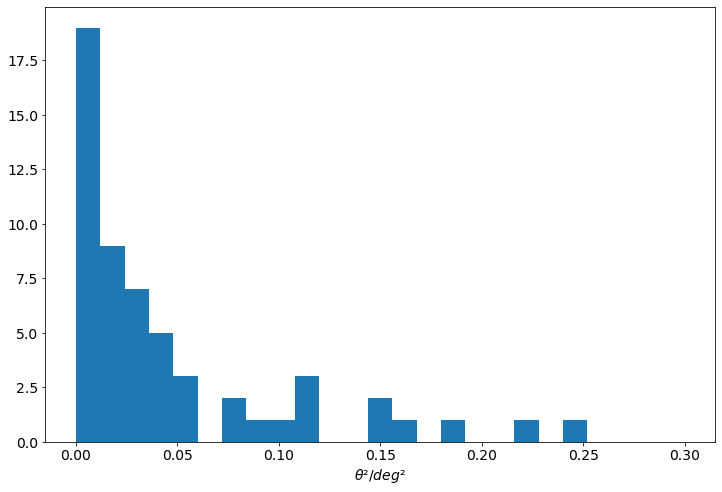

In [29]:
from astropy.coordinates.angle_utilities import angular_separation
import pandas as pd


df_rec = pd.read_hdf(f.name, key='events/reconstructed')
df_true = pd.read_hdf(f.name, key='events/true')


theta = angular_separation(
    df_rec.az.values * u.deg, df_rec.alt.values * u.deg,
    df_true.az.values * u.deg, df_true.alt.values * u.deg,
)

plt.hist(theta.to(u.deg).value**2, bins=25, range=[0, 0.3])
plt.xlabel(r'$\theta² / deg²$')
None

## ArrayDisplay


(-400, 400)

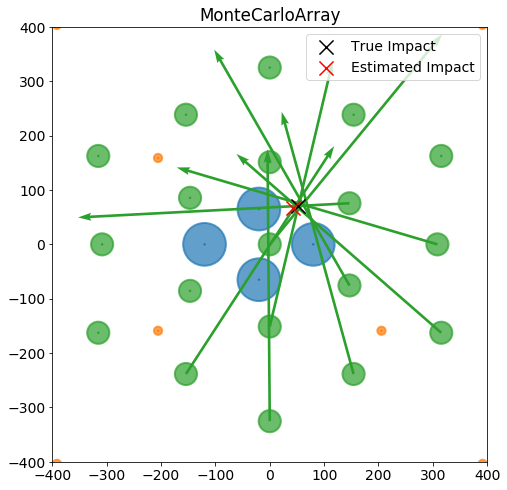

In [30]:
from ctapipe.visualization import ArrayDisplay


angle_offset = plotting_event.mcheader.run_array_direction[0]


disp = ArrayDisplay(plotting_event.inst.subarray)

disp.set_vector_hillas(
    plotting_hillas,
    time_gradient=plotting_timing,
    angle_offset=angle_offset,
    length=500
)

plt.scatter(
    plotting_event.mc.core_x, plotting_event.mc.core_y,
    s=200, c='k', marker='x', label='True Impact',
)
plt.scatter(
    plotting_stereo.core_x, plotting_stereo.core_y,
    s=200, c='r', marker='x', label='Estimated Impact',
)

plt.legend()
plt.xlim(-400, 400)
plt.ylim(-400, 400)

## LST Mono with output


* Let's use the `HDF5TableWriter` to save the dl1 Hillas parameter data to an hdf5 file
* This is not ideal yet and one of the major points to be discussed in two weeks

In [31]:
from ctapipe.io import HDF5TableWriter
from ctapipe.core.container import Container, Field

input_url = get_dataset_path('gamma_test_large.simtel.gz')

source = event_source(
    input_url,
    allowed_tels=[1, 2, 3, 4], # only use the first LST
)

calibrator = CameraCalibrator(subarray=source.subarray)

class EventInfo(Container):
    event_id = Field('event_id')
    obs_id =  Field('obs_id')
    telescope_id = Field('telescope_id')
    

with HDF5TableWriter(filename='hillas.h5', group_name='dl1', mode='w') as writer:

    for event in source:
        print('Id: {}, E = {:1.3f}, Telescopes: {}'.format(event.count, event.mc.energy, len(event.r0.tel)))
    
        calibrator(event)
    
        for telescope_id, dl1 in event.dl1.tel.items():      

            camera = event.inst.subarray.tels[telescope_id].camera
            image = dl1.image
            pulse_time = dl1.pulse_time

            boundary, picture, min_neighbors = cleaning_level[camera.cam_id]

            clean = tailcuts_clean(
                camera, 
                image,
                boundary_thresh=boundary,
                picture_thresh=picture,
                min_number_picture_neighbors=min_neighbors
            )
            
            if clean.sum() < 5:
                continue
            
            event_info = EventInfo(event_id=event.r0.event_id, obs_id=event.r0.obs_id, telescope_id=telescope_id)
            hillas_c = hillas_parameters(camera[clean], image[clean])
            leakage_c = leakage(camera, image, clean)
            timing_c = timing_parameters(camera, image, pulse_time, hillas_c, clean)

            writer.write('events', [event_info, event.mc, hillas_c, leakage_c, timing_c])
    


Id: 0, E = 1.864 TeV, Telescopes: 2


Id: 1, E = 0.017 TeV, Telescopes: 2


Id: 2, E = 0.010 TeV, Telescopes: 2
Id: 3, E = 0.121 TeV, Telescopes: 4


Id: 4, E = 0.032 TeV, Telescopes: 3
Id: 5, E = 0.073 TeV, Telescopes: 1
Id: 6, E = 0.129 TeV, Telescopes: 1


Id: 7, E = 0.079 TeV, Telescopes: 2


Id: 8, E = 0.127 TeV, Telescopes: 3
Id: 9, E = 0.147 TeV, Telescopes: 1


Id: 10, E = 0.103 TeV, Telescopes: 1
Id: 11, E = 0.078 TeV, Telescopes: 1
Id: 12, E = 0.592 TeV, Telescopes: 1


Id: 13, E = 0.066 TeV, Telescopes: 2


Id: 14, E = 0.017 TeV, Telescopes: 3


Id: 15, E = 0.009 TeV, Telescopes: 2
Id: 16, E = 0.248 TeV, Telescopes: 4


Id: 17, E = 5.327 TeV, Telescopes: 3


Id: 18, E = 0.407 TeV, Telescopes: 4
Id: 19, E = 0.037 TeV, Telescopes: 3


Id: 20, E = 0.020 TeV, Telescopes: 4


Id: 21, E = 0.710 TeV, Telescopes: 3


Id: 22, E = 0.055 TeV, Telescopes: 2
Id: 23, E = 0.032 TeV, Telescopes: 2


Id: 24, E = 0.118 TeV, Telescopes: 1


Id: 25, E = 0.142 TeV, Telescopes: 1


Id: 26, E = 0.189 TeV, Telescopes: 4
Id: 27, E = 0.037 TeV, Telescopes: 3


Id: 28, E = 0.112 TeV, Telescopes: 1
Id: 29, E = 0.322 TeV, Telescopes: 4


In [32]:
import pandas as pd

df = pd.read_hdf('hillas.h5', key='dl1/events')
df.set_index(['obs_id', 'event_id', 'telescope_id'], inplace=True)
df.head()

alt        az      core_x      core_y  \
obs_id event_id telescope_id                                                
7514   31012    2             68.478978  6.384091   51.675117   69.654037   
                3             68.478978  6.384091   51.675117   69.654037   
       90914    2             70.676229  3.107417 -113.833435 -142.343872   
                4             70.676229  3.107417 -113.833435 -142.343872   
       153614   1             68.949967  2.666187  -51.531204 -106.752579   

                              deviation    energy   h_first_int     intensity  \
obs_id event_id telescope_id                                                    
7514   31012    2              0.727610  1.863750  18171.726562    475.328941   
                3              0.731793  1.863750  18171.726562  24086.055066   
       90914    2              0.167130  0.016544  15776.052734     78.789463   
                4              0.439378  0.016544  15776.052734    110.688692   
       153614   1              0.097485  0.010250  19824.572266     76.273207   

                              intensity_width_1  intensity_width_2  ...  \
obs_id event_id telescope_id                                        ...   
7514   31012    2                      0.651719           0.862295  ...   
                3                      0.114085           0.272478  ...   
       90914    2                      0.000000           0.000000  ...   
                4                      0.000000           0.000000  ...   
       153614   1                      0.000000           0.000000  ...   

                                    psi         r  shower_primary_id  \
obs_id event_id telescope_id                                           
7514   31012    2             61.214904  1.046389                  0   
                3            -75.490119  0.927823                  0   
       90914    2             51.701245  0.901478                  0   
                4             82.347736  0.961931                  0   
       153614   1             73.286384  0.966727                  0   

                              skewness     slope  slope_err     width  \
obs_id event_id telescope_id                                            
7514   31012    2             0.229954 -4.642429   0.454183  0.044190   
                3             1.562733  1.033806   0.116695  0.079858   
       90914    2            -0.056639  6.080121   2.028667  0.017989   
                4             0.050001  0.512108   2.245865  0.024432   
       153614   1            -0.310947 -4.593914   0.784456  0.020285   

                                     x       x_max         y  
obs_id event_id telescope_id                                  
7514   31012    2            -0.963161  379.538452  0.408964  
                3            -0.574394  379.538452  0.728648  
       90914    2             0.564170  184.545456  0.703117  
                4             0.341674  184.545456  0.899205  
       153614   1            -0.457182  241.111115  0.851789  

[5 rows x 27 columns]

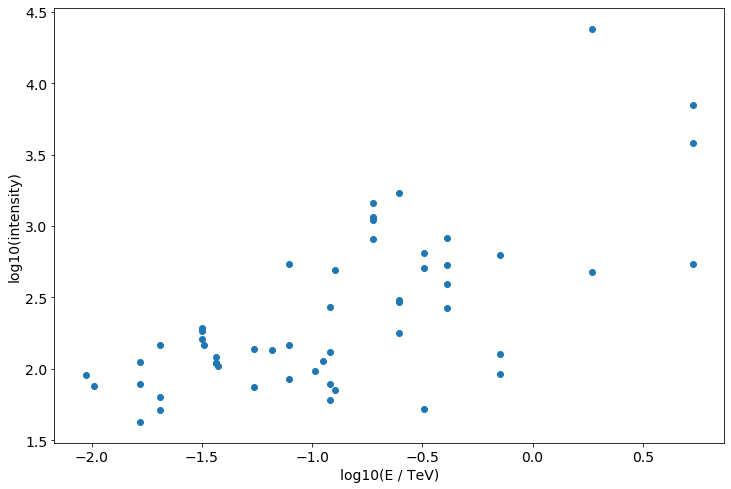

In [33]:
plt.scatter(np.log10(df.energy), np.log10(df.intensity))
plt.xlabel('log10(E / TeV)')
plt.ylabel('log10(intensity)')
None

## Isn't python slow?

* Many of you might have heard: "Python is slow".
* That's trueish.
* All python objects are classes living on the heap, event integers.
* Looping over lots of "primitives" is quite slow compared to other languages.

⇒ Vectorize as much as possible using numpy  
⇒ Use existing interfaces to fast C / C++ / Fortran code  
⇒ Optimize using cython or numba  

**But: "Premature Optimization is the root of all evil" — Donald Knuth**

So profile to find exactly what is slow.

### Why use python then?

* Python works very well as *glue* for libraries of all kinds of languages
* Python has a rich ecosystem for data science, physics, algorithms, astronomy

### Example: Number of Islands

Find all groups of pixels, that survived the cleaning

In [34]:
from ctapipe.image import toymodel
from ctapipe.instrument import CameraGeometry


camera = CameraGeometry.from_name('LSTCam')

Sampling rate is not in file, defaulting to 1.0 GHz


Let's create a toy images with several islands;

In [35]:
np.random.seed(42)

image = np.zeros(camera.n_pixels)


for i in range(9):
    
    model = toymodel.Gaussian(
        x=np.random.uniform(-0.8, 0.8) * u.m,
        y=np.random.uniform(-0.8, 0.8) * u.m,
        width=np.random.uniform(0.05, 0.075) * u.m,
        length=np.random.uniform(0.1, 0.15) * u.m,
        psi=np.random.uniform(0, 2 * np.pi) * u.rad,
    )

    new_image, sig, bg = model.generate_image(
        camera, 
        intensity=np.random.uniform(1000, 3000),
        nsb_level_pe=5
    )
    image += new_image

In [36]:
clean = tailcuts_clean(camera, image, picture_thresh=10, boundary_thresh=5, min_number_picture_neighbors=2)

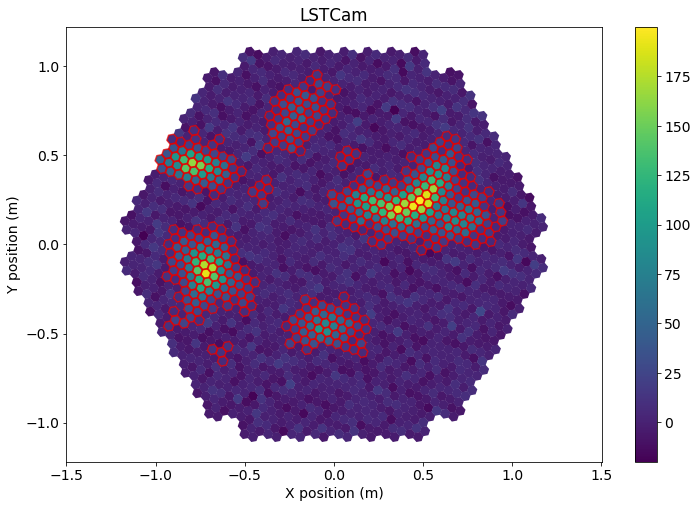

In [37]:
disp = CameraDisplay(camera)
disp.image = image
disp.highlight_pixels(clean, color='xkcd:red', linewidth=1.5)
disp.add_colorbar()

In [38]:
def num_islands_python(camera, clean):
    ''' A breadth first search to find connected islands of neighboring pixels in the cleaning set'''
    
    # the camera geometry has a [n_pixel, n_pixel] boolean array
    # that is True where two pixels are neighbors
    neighbors = camera.neighbor_matrix
    
    island_ids = np.zeros(camera.n_pixels)
    current_island = 0
    
    # a set to remember which pixels we already visited
    visited = set()

    # go only through the pixels, that survived cleaning
    for pix_id in np.where(clean)[0]:
        if pix_id not in visited:
            # remember that we already checked this pixel
            visited.add(pix_id)
            
            # if we land in the outer loop again, we found a new island
            current_island += 1
            island_ids[pix_id] = current_island
            
            # now check all neighbors of the current pixel recursively
            to_check = set(np.where(neighbors[pix_id] & clean)[0])
            while to_check:
                pix_id = to_check.pop()
                
                if pix_id not in visited:    
                    visited.add(pix_id)
                    island_ids[pix_id] = current_island
                    
                    to_check.update(np.where(neighbors[pix_id] & clean)[0])
    
    n_islands = current_island
    return n_islands, island_ids

In [39]:
n_islands, island_ids = num_islands_python(camera, clean)

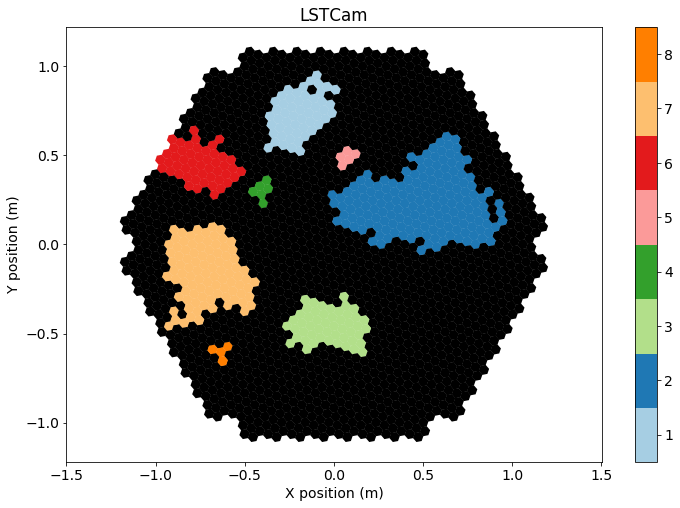

In [40]:
from matplotlib.colors import ListedColormap

cmap = plt.get_cmap('Paired')
cmap = ListedColormap(cmap.colors[:n_islands])
cmap.set_under('k')

disp = CameraDisplay(camera)
disp.image = island_ids
disp.cmap = cmap
disp.set_limits_minmax(0.5, n_islands + 0.5)
disp.add_colorbar()

In [41]:
%timeit num_islands_python(camera, clean)

2.13 ms ± 25.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
from scipy.sparse.csgraph import connected_components

def num_islands_scipy(camera, clean):
    neighbors = camera.neighbor_matrix_sparse
    
    clean_neighbors = neighbors[clean][:, clean]
    num_islands, labels = connected_components(clean_neighbors, directed=False)
    
    island_ids = np.zeros(camera.n_pixels)
    island_ids[clean] = labels + 1
    
    return num_islands, island_ids

In [43]:
n_islands_s, island_ids_s = num_islands_scipy(camera, clean)

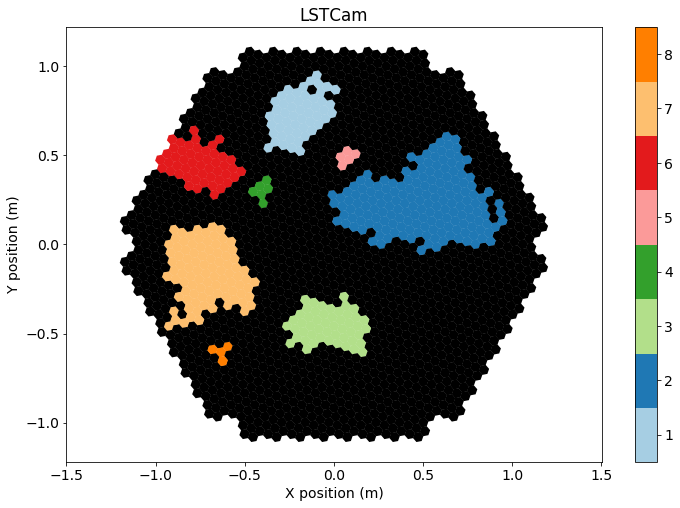

In [44]:
disp = CameraDisplay(camera)
disp.image = island_ids_s
disp.cmap = cmap
disp.set_limits_minmax(0.5, n_islands_s + 0.5)
disp.add_colorbar()

In [45]:
%timeit num_islands_scipy(camera, clean)

516 µs ± 5.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**A lot less code, and a factor 3 speed improvement**